# EDA of Correlations within Data

In [1]:
import h5py

import numpy   as np
import pandas  as pd
import seaborn as sns

import matplotlib.pyplot as plt
plt.style.use('../histograms.mplstyle')

import scipy.stats

from matplotlib.ticker import ScalarFormatter

## Brief data inspection

In [2]:
# path to data file
FILE_NAME = "../data/RUN001231_channels.h5"

# get keys
f = h5py.File(FILE_NAME, "r")
keys = f.keys()

# build the dataset by concatenating all channels together
df = pd.concat(
    [
        pd.read_hdf(FILE_NAME, key=k, mode="r") for k in keys
    ],
    ignore_index=True
)

# rename columns
df = df.rename(columns={"CH":"ch", "HIT_DRIFT_TIME":"drift_time", "THETA":"theta"})

print(f"Shape: {df.shape}")
print(f'Features: {list(df.columns)}')

Shape: (236533, 4)
Features: ['ch', 'drift_time', 'm', 'theta']


### Visualization

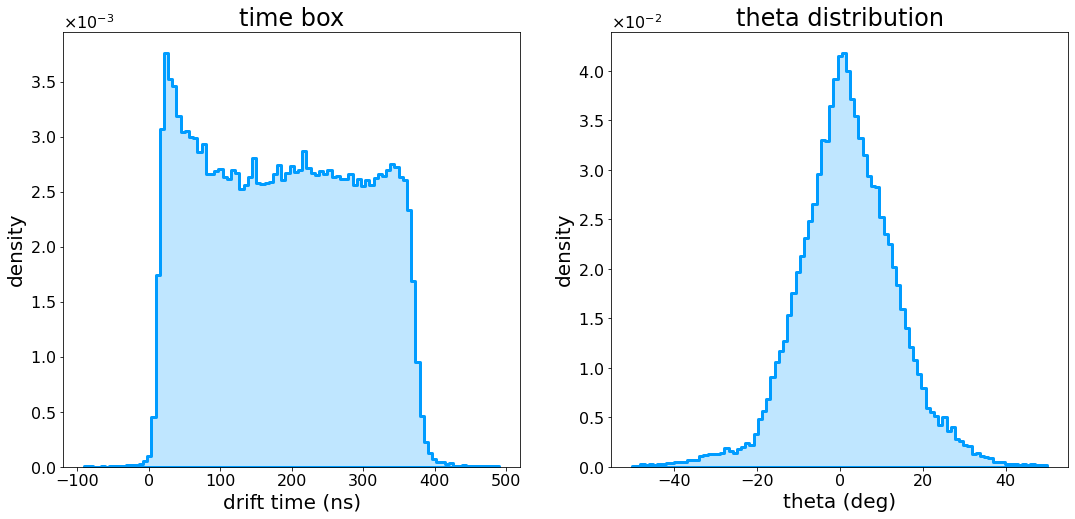

In [3]:
# BINS:
# drift time
dt_bins    = np.linspace(-90, 490, 100)
# theta
theta_bins = np.linspace(-50, 50 ,100)

fig, ax = plt.subplots(ncols=2, figsize=(18,8))

ax[0].set_title("time box")
ax[0].set_xlabel("drift time (ns)")
ax[0].set_ylabel("density")

ax[1].set_title("theta distribution")
ax[1].set_xlabel("theta (deg)")
ax[1].set_ylabel("density")

# drift time distribution
sns.histplot(
    x         = df.drift_time,
    bins      = dt_bins,
    stat      = "density",
    element   = "step",
    fill      = True,
    color     = "#aadeff",
    edgecolor = "#009cff",
    linewidth = 3,
    label     = "full dataset",
    ax        = ax[0]
)

# theta distribution
sns.histplot(
    x         = df.theta,
    bins      = theta_bins,
    stat      = "density",
    element   = "step",
    fill      = True,
    color     = "#aadeff",
    edgecolor = "#009cff",
    linewidth = 3,
    label     = "full dataset",
    ax        = ax[1]
)

# exponential y ticks
ax[0].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax[0].ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
ax[1].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax[1].ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))

plt.show()

### Correlation coefficient

In [4]:
# correlation coefficient and its p-value
# note that I'm considering the absolute value of the angular feature:
# due to its simmetry I believe that we can get more statistical significance if we do so
r, p = scipy.stats.pearsonr(df.drift_time, np.abs(df.theta))
# set a confidence level at 5%
alpha = 0.05

print(f"Correlation coefficient between drift time and theta: {r:.5f}")
print(f"p-value = {p:.2e}")
print("Statistically significant:", "YES" if p < alpha else "NO")

Correlation coefficient between drift time and theta: -0.02834
p-value = 3.21e-43
Statistically significant: YES


### Covariance matrix

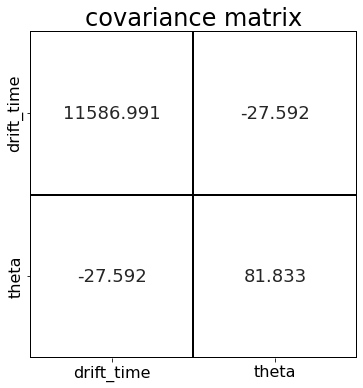

In [5]:
# covariance matrix
# note that I'm still considering the absolute value of theta
cov = np.cov([df.drift_time, np.abs(df.theta)])

textcolors = ["white", "black"]
ticklabels = ["drift_time","theta"]

fig, ax = plt.subplots(figsize=(6,6)) 
ax.set_title("covariance matrix")        

# plot of the covariance matrix
sns.heatmap(
    data        = cov,
    cmap        = ["white"],
    linecolor   = "black",
    linewidth   = 2,
    xticklabels = ticklabels, 
    yticklabels = ticklabels,
    robust      = True,
    annot       = True,
    fmt         = ".3f",
    annot_kws   = {"fontsize":18},
    cbar        = False,
    square      = True,
    ax          = ax
)

plt.show()

## Cutting the angular feature

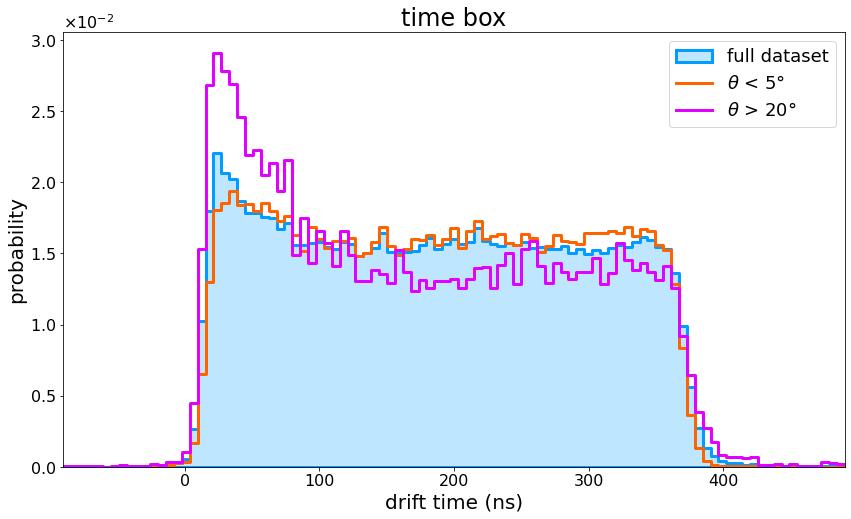

In [ ]:
# binning drift time
bins = np.linspace(-90, 490, 100)
binwidth = bins[1] - bins[0]
bincenters = 0.5 * (bins[1:]+bins[:-1])

# CUTS:
# theta lower than |5°|
cut_1 = np.abs(df.theta) < 5
# theta higher than |20°|
cut_2 = np.abs(df.theta) > 20


fig, ax = plt.subplots()

ax.set_title("time box")
ax.set_xlabel("drift time (ns)")
ax.set_ylabel("probability")        # using probability instead of density

ax.set_xlim(bins[0], bins[-1])


# full dataset - drift time distribution
sns.histplot(
    x         = df.drift_time,
    bins      = bins,
    stat      = "probability",
    element   = "step",
    fill      = True,
    color     = "#aadeff",
    edgecolor = "#009cff",
    linewidth = 3,
    label     = "full dataset",
    ax        = ax
)

# theta lower than |5°| - drift time distribution
sns.histplot(
    x         = df[cut_1].drift_time,
    bins      = bins,
    stat      = "probability",
    element   = "step",
    fill      = False,
    color     = "#ff6300",
    linewidth = 3,
    label     = r"$\theta$ < 5°",
    ax        = ax
)

# theta higher than |20°| - drift time distribution
sns.histplot(
    x         = df[cut_2].drift_time,
    bins      = bins,
    stat      = "probability",
    element   = "step",
    fill      = False,
    color     = "#e200ff",
    linewidth = 3,
    label     = r"$\theta$ > 20°",
    ax        = ax
)



# exponential y ticks
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))

ax.legend(fontsize=18)

plt.show()

## Possible breakthrough: correlation with cuts

In [77]:
def normalize(hist, bin_edges):
    """normalizes an histogram such that the sum of bin heights is equal to 1

    Args:
        hist      (np.ndarray): bin heights
        bin_edges (np.ndarray): bin edges
        
    Return:
        norm_hist (np.ndarray): normalized bin heights
    """
    return (hist / np.sum(hist))

In [115]:
thetas = [
    5,
    10,
    15,
    20,
    25,
    30,
    35,
    40,
    45,
    50,
]
low_cuts = [
    np.abs(df.theta) < theta for theta in thetas
]
high_cuts = [
    np.abs(df.theta) > theta for theta in thetas
]

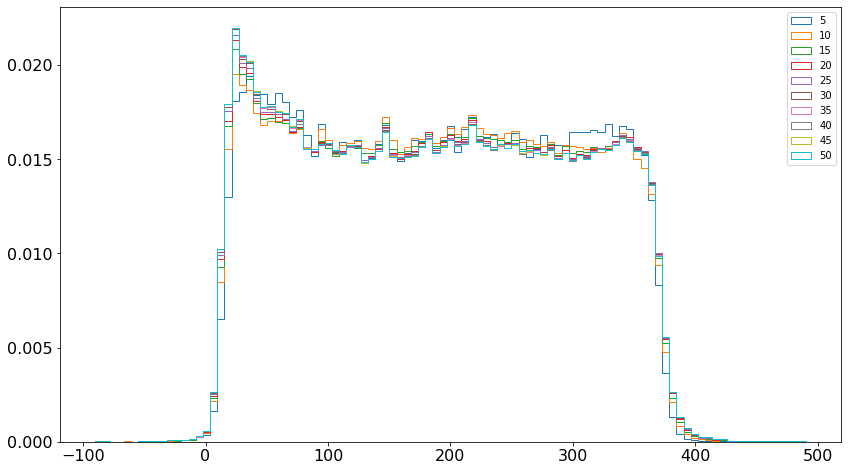

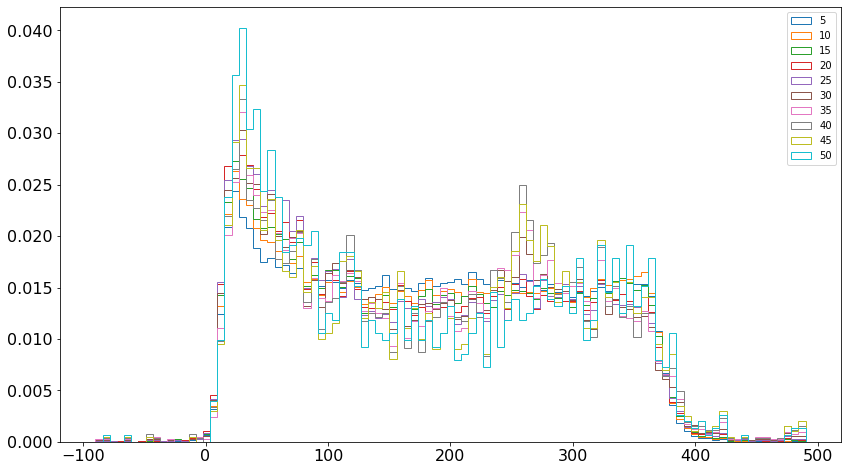

In [117]:
low_hists = [normalize(*np.histogram(df[cut].drift_time, bins=bins)) for cut in low_cuts]
low_peaks = [h.max() for h in low_hists]

for h, theta in zip(low_hists, thetas):
    plt.hist(bins[:-1], bins=bins, weights=h, label=str(theta), histtype="step")

plt.legend()
plt.show()

high_hists = [normalize(*np.histogram(df[cut].drift_time, bins=bins)) for cut in high_cuts]
high_peaks = [h.max() for h in high_hists]

for h, theta in zip(high_hists, thetas):
    plt.hist(bins[:-1], bins=bins, weights=h, label=str(theta), histtype="step")

plt.legend()
plt.show()


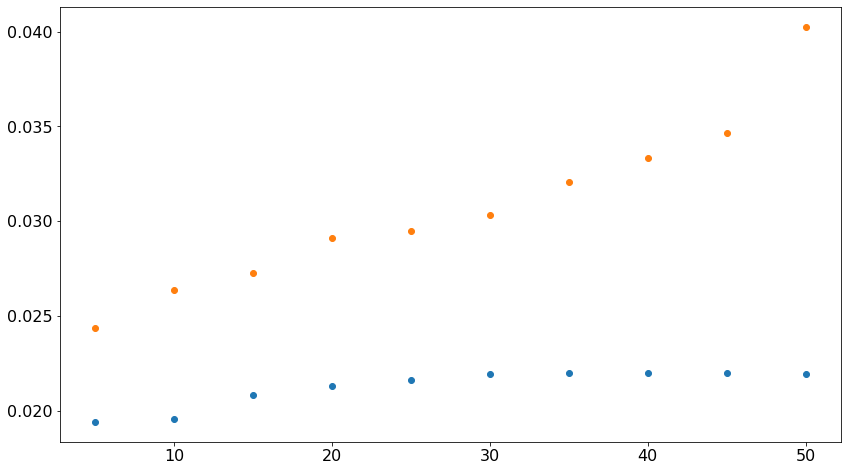

In [121]:
fig, ax = plt.subplots()

ax.scatter(thetas, low_peaks)
ax.scatter(thetas, high_peaks)

plt.show()